# COMP 135 Spring 2019: HW2 Solution Notebook

## Setup comp135_env package imports¶


In [288]:
import os
import numpy as np
import warnings

import sklearn.preprocessing
import sklearn.pipeline
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection

from matplotlib import pyplot as plt
import seaborn as sns

In [289]:
%matplotlib inline

## Setup student-defined imports

In [290]:
# None needed

## Load Auto dataset for Problem 1

In [291]:
x_tr_MF = np.loadtxt('data_auto/x_train.csv', delimiter=',', skiprows=1)
x_va_NF = np.loadtxt('data_auto/x_valid.csv', delimiter=',', skiprows=1)
x_te_PF = np.loadtxt('data_auto/x_test.csv', delimiter=',', skiprows=1)

In [292]:
y_tr_M = np.loadtxt('data_auto/y_train.csv', delimiter=',', skiprows=1)
y_va_N = np.loadtxt('data_auto/y_valid.csv', delimiter=',', skiprows=1)
y_te_P = np.loadtxt('data_auto/y_test.csv', delimiter=',', skiprows=1)

## Problem 1a: Polynomial Degree Selection on Fixed Validation Set

#### **1a(i):** Plot the number of polynomial features $G$ vs. degree $D$

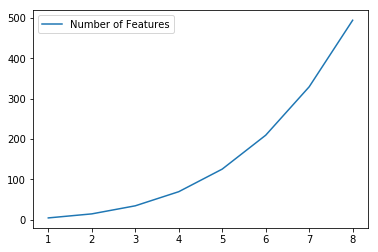

In [293]:
degree_list = [1, 2, 3, 4, 5, 6, 7, 8]
num_poly_feat_list = []
for degree in degree_list:    
    poly_transformer = sklearn.preprocessing.PolynomialFeatures(
        degree=degree, include_bias=False)
    x_tr_MG=poly_transformer.fit_transform(x_tr_MF)
    num_feat=x_tr_MG.shape[1]
    num_poly_feat_list.append(num_feat)
##print(num_poly_feat_list)
plt.plot(degree_list, num_poly_feat_list, label='Number of Features')
plt.legend()
plt.show()

#### The number of features is growing faster and faster.

### 1a(ii): Fit a linear regression model to a polynomial feature transformation of the provided training set of $x$, $y$ values at each of these possible degrees: [1, 2, 3, 4, 5, 6].


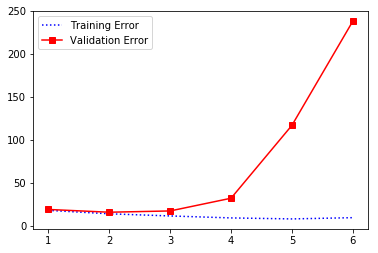

In [294]:
degree_list = [1, 2, 3, 4, 5, 6]
err_tr_list = []
err_va_list = []
coef_list = []
for degree in degree_list:
    poly_transformer = sklearn.preprocessing.PolynomialFeatures(
        degree=degree, include_bias=False)
    x_tr_MG=poly_transformer.fit_transform(x_tr_MF)
    #print(x_tr_MG.shape)
    reg = sklearn.linear_model.LinearRegression().fit(x_tr_MG, y_tr_M)
    
    #get coefficient
    c=list(reg.coef_)
    c.append(reg.intercept_)
    #print(len(c))
    coef_list.append(c);
    
    #get training mse
    dif_tr=y_tr_M-reg.predict(x_tr_MG)
    mse_tr=1/dif_tr.shape[0]*np.dot(dif_tr,dif_tr)
    err_tr_list.append(mse_tr)
    
    #get valid mse
    x_va_MG=poly_transformer.fit_transform(x_va_NF)
    dif_va=y_va_N-reg.predict(x_va_MG)
    mse_va=1/dif_va.shape[0]*np.dot(dif_va,dif_va)
    err_va_list.append(mse_va)
    
##print (coef_list)
##print(err_tr_list)
##print(err_va_list)

plt.plot(degree_list, err_tr_list, 'b:', label='Training Error')
plt.plot(degree_list, err_va_list, 'rs-', label='Validation Error')
plt.legend()
plt.show()

### **1a(iii):** Based on this plot, which single degree value do you recommend? Why?

2. It has least mse in validation set and the computational cost is low (with less parameters).

### **1a(iv):** Report the numerical values of the 5th percentile and 95th percentile of the coefficients observed in your linear regression model for degrees 3, 4, 5, and 6. What seems to be happening?

In [295]:
for i in range(3,6):
    Num5P=np.floor(0.05*len(coef_list[i]))
    Num95P=np.ceil(0.95*len(coef_list[i]))
    Num5P=Num5P.astype(int);
    Num95P=Num95P.astype(int);
    print('Degree ', i, ' 5%:', coef_list[i][0:Num5P])
    print('Degree ', i, '95%:', coef_list[i][Num95P: len(coef_list[i])-1])

Degree  3  5%: [2.779327943826762, -0.46425858777657025, -0.005306223013220241]
Degree  3 95%: [-7.395334313450375e-05, 3.8254714603003226e-07]
Degree  4  5%: [-0.0003183090637989265, 0.00013827221056066742, -1.692701929767107e-05, -2.0055658997639153e-07, -4.943446285261895e-06, -3.833396467065371e-05]
Degree  4 95%: [-3.919490476752643e-05, -0.0012688788792116557, 4.145682053874722e-05, 3.9137755778018895e-07, -1.3030182280767417e-08]
Degree  5  5%: [1.9109123216258055e-08, -2.9143497252624494e-09, -2.465653225405581e-09, -2.9060226728729757e-10, 3.4208743733484904e-11, -1.463930173436295e-10, 5.910866684801363e-12, 1.947999156420853e-11, 6.741634396516043e-11, 4.3592911043066275e-11]
Degree  5 95%: [-4.00088595427297e-09, 4.496828483141739e-11, -5.338131364963203e-13, 2.0989637232349073e-11, 4.140862222813379e-11, -1.0837701073373435e-08, -8.102029556802606e-08, 1.254707331092048e-08, -2.162922919801099e-10]


They tends to go very close to zero.

### **1a(v):** Comment on the training error observed at degree 6. Based on your formulas from **1a(i)** and your knowledge of linear regression, what **should** the training error be at degree 6? What do you think is happening instead?

The error of degree 6 goes higher than degree 5.  
In general, the error should be zero as there are more features than coef.  
This means the computer could not solve the problem well as the feature vandermonde matrix X is ill-conditioned, which has a big condition number(see below). SKlearn uses persudo inverse to solve least square problems, which involves SVD. The multi-feature vandermonde matrix X will go nearly singular when the degree is high, which leads to an inaccurate calculation for SVD and thus persudo-inverse. Even for normal equation we used in class, this will cause big errors."

In [296]:
np.linalg.cond(x_tr_MG)

1.3461920984838324e+33

# 1b: Linear regression with Rescaled Polynomial Bases

Setup code below to make a pipeline

In [297]:
def make_pipeline(degree=None):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('poly_rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('linear_regr', sklearn.linear_model.LinearRegression()),
        ])
    
    # Define utility method that performs all the feature transforms of the pipeline in order.
    def calc_features(x):
        ''' Maps input features to rescaled polynomial features
        '''
        feat = x
        for step_name, step_tfmr in pipeline.steps[:-1]:
            feat = step_tfmr.transform(feat)
        return feat
    pipeline.calc_features = calc_features
    
    # Define utility method that accesses the linear regression weights
    pipeline.get_linear_regr_weights = lambda: pipeline.named_steps['linear_regr'].coef_

    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

In [298]:
degree_list = [1, 2, 3, 4, 5, 6]
err_tr_list = []
err_va_list = []
pipeline_list = []

# TODO fit model at each degree and track error metrics
for degree in degree_list:
    poly_fit=make_pipeline(degree)
    poly_fit.fit(x_tr_MF, y_tr_M)
    
    #get training mse
    dif_tr=y_tr_M-poly_fit.predict(x_tr_MF)
    mse_tr=1/dif_tr.shape[0]*np.dot(dif_tr,dif_tr)
    err_tr_list.append(mse_tr)
    
    #get valid mse
    dif_va=y_va_N-poly_fit.predict(x_va_NF)
    mse_va=1/dif_va.shape[0]*np.dot(dif_va,dif_va)
    err_va_list.append(mse_va)
    
    pipeline_list.append(poly_fit)
    
##print (err_tr_list)
##print (err_va_list)

#### 1b(i): Plot MSE for *rescaled* polynomial features vs. degrees

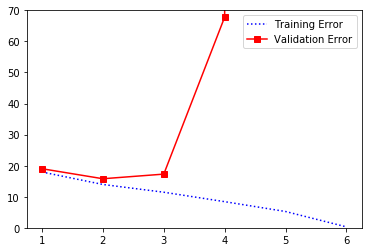

In [299]:
plt.plot(degree_list, err_tr_list, 'b:', label="Training Error")
plt.plot(degree_list, err_va_list, 'rs-', label="Validation Error")
plt.ylim(0,70)
plt.legend()
plt.show()

### **1b(ii):** Using this new analysis, which degree do you recommend? 


Still 2.

### **1b(iii):** Report the numerical values of the 5th percentile and 95th percentile of the coefficients observed in this most recent linear regression model at all degrees. What seems to be happening? What's different than in **1a**?

In [300]:
for i in range(1,6):
    features=pipeline_list[i].get_linear_regr_weights()
    Num5P=np.ceil(0.05*len(features))
    Num95P=np.floor(0.95*len(features))
    Num5P=Num5P.astype(int);
    Num95P=Num95P.astype(int);
    print('Degree ', i, ' 5%:', features[0:Num5P])
    print('Degree ', i, '95%:', features[Num95P: len(coef_list[i])-1])

Degree  1  5%: [-40.72382583]
Degree  1 95%: [52.64870837]
Degree  2  5%: [-51.30784591  -0.18962152]
Degree  2 95%: [-1696.7703392   1025.55311573]
Degree  3  5%: [  617.44783208  -191.08377605  1774.23863576 -1343.55587852]
Degree  3 95%: [-12796.21288058  55023.34640694 -56683.52781788  17563.69104935]
Degree  4  5%: [ 6.05590416e+11  8.63945896e+10  7.07304500e+11  2.18256390e+11
 -6.64566085e+11 -5.82930813e+11 -4.79242813e+12]
Degree  4 95%: [-1.12526114e+06  2.15781912e+11 -6.50223536e+11  3.81745683e+11
 -5.11751855e+05 -7.65297826e+05  5.73201097e+05]
Degree  5  5%: [ 5.14336982e+10 -3.59190661e+10  4.56095762e+10 -2.35430188e+10
  1.12459333e+10 -5.85649458e+10 -4.30289567e+11 -1.10059237e+10
  5.14481475e+10  1.91068577e+11 -2.65253594e+10]
Degree  5 95%: [-4.01445290e+10  1.73474369e+10  7.31763131e+08 -1.35495266e+09
 -4.62962317e+11  6.42847850e+11 -1.55819876e+10 -7.24796134e+09
 -1.65923923e+10  8.99654681e+09 -5.22221985e+07]


**Answer**:   
The coeficient goes really big.  
The difference is all data are scaled into a small range so the coeficient are rescaled accordingly. By the nature of least square fitting, if one feature scaled to $\frac{1}{n}$ of the origin data, the coeficient will get larger by n times. This also shows the data is over fitting as the coefficient is large.

**Answer 1b(v)**:  
The training error of degree 6 goes to 0.3.  
We are expecting an error of 0, so this is much closer to what we expects, much better than 1a. However, this is still not ideal.  
The difference is that the data are rescaled to a reasonable range so the matrix X is probably much better conditioned. However, X is still pretty singular because 0.3 is still far larger than a machine error.

# 1c: Cross Validation setup

Combine original train/valid splits into one mega dataset

In [301]:
x_trva_LF = np.vstack([x_tr_MF, x_va_NF])
y_trva_L = np.hstack([y_tr_M, y_va_N])

### **Coding Step 1/1:** Complete the starter code function 

In [302]:
def calc_mean_squared_error_across_k_folds(
        model, x_LF, y_L, K=5, random_state=0):
    ''' Calculate mean squared error on K cross-validation folds
    
    Args
    ----
    model: sklearn predictor object
        has `fit` and `predict` methods
    x_LF : 2D array, size n_examples x n_features
        
    y_L : 1D array, size n_examples
    K : int
    random_state : int or np.random.RandomState instance
    
    Returns
    -------
    mse_scores_K : 1D array, size K
        estimate of MSE on each of the K folds
    '''
    kfold_iterator = sklearn.model_selection.KFold(
        n_splits=K, shuffle=True, random_state=random_state)
    
    # TODO compute mse on each of the K folds
    va_mse=[];
    for ind_tr, ind_va in kfold_iterator.split(x_LF):
        x_tr, x_va = x_LF[ind_tr], x_LF[ind_va]
        y_tr, y_va = y_L[ind_tr], y_L[ind_va]
        model.fit(x_tr, y_tr)
    
        #get valid mse
        dif_va=y_va-model.predict(x_va)
        mse_va=1/dif_va.shape[0]*np.dot(dif_va,dif_va)
        va_mse.append(mse_va)
        
        #print(mse_va)
    #print(sum_tr/K, sum_va/K)
    return va_mse

### **1c(i):** Using your `calc_mean_squared_error_across_k_folds` function with 10 folds, make a line plot of the *average* mean-squared-error at degrees 1, 2, 3, 4, 5, 6. 

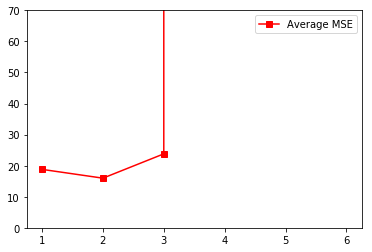

In [303]:
degree_list = [1, 2, 3, 4, 5, 6]
err_va_list = []

# TODO fit model at each degree and track error metrics
for degree in degree_list:
    err=calc_mean_squared_error_across_k_folds(make_pipeline(degree), x_trva_LF, y_trva_L,K=10)
    
    err_va_list.append(np.mean(err))

plt.plot(degree_list, err_va_list, 'rs-', label="Average MSE")
plt.ylim(0,70)
plt.legend()
plt.show()

#### **1c(ii):** Based on this plot, what is your recommended degree? How do your recommendations differ from *1b*?

**Answer**: Still 2. It's the same recommendations. It has the least va error.  
As far as I'm concerned, as the set up of random generator might be different. So it might give other result on different machines. 

#### **1c(iii):** For each $K$, make a scatter plot of the $K$ fold-specific estimates of MSE ($K$ is x-axis, MSE on y-axis). Also draw a line connecting the average MSE across $K$.

In [304]:
degree = 3
K_list = [2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]
pipeline = make_pipeline(degree)
err_va_list = []
avg_score_list=[]
# TODO
for Kval in K_list:
    ##print(Kval)
    err=calc_mean_squared_error_across_k_folds(pipeline, x_trva_LF, y_trva_L,K=Kval)
    
    err_va_list.append(err)
    avg_score_list.append(np.mean(err))
#print(len(err_va_list))

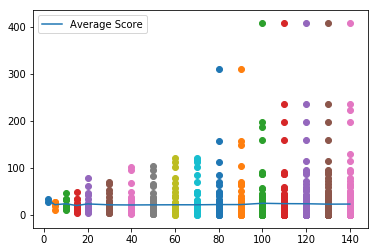

In [305]:
fig,ax = plt.subplots()

for i in range(0,len(K_list)):
    ax.scatter(K_list[i]*np.ones(len(err_va_list[i])),err_va_list[i])
ax.plot(K_list,avg_score_list, label="Average Score")       
#plt.ylim(0,70)
plt.legend()
plt.show()

#### **1c(iv):** What happens to the distribution of MSE as you use more and more folds? Is the trend observed in Plot **1c(iii)** what we expect based on your readings from the ISL textbook Chapter 5? 


The mse becomes highly variable. And also there are some outliers with more number of folds(causing mean to be bigger).   
Yes, this fit the conclusion of high variability and over-estimating(big mse).

# Problem 2: Regularized Linear Regression via L2 and L1 penalties

### Setup Pipeline for Problem 2a: Grid Search for L2

In [306]:
alpha_grid = np.logspace(-9, 6, 31)

In [307]:
def make_L2regularized_pipeline(degree=2, alpha=1.0):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('poly_rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('linear_regr', sklearn.linear_model.Ridge(alpha=alpha)),
        ])
    
    # Define utility method that performs all the feature transforms of the pipeline in order.
    def calc_features(x):
        tmp = x
        for step_name, step_tfmr in pipeline.steps[:-1]:
            tmp = step_tfmr.transform(tmp)
        return tmp
    pipeline.calc_features = calc_features
    
    pipeline.get_linear_regr_weights = lambda: pipeline.named_steps['linear_regr'].coef_
    pipeline.get_linear_regr_bias = lambda: pipeline.named_steps['linear_regr'].intercept_

    return pipeline

## Problem 2a: Grid Search for L2

### **2a(i):** Train `Ridge` regression across grid of possible L2-penalty strengths $\alpha$. Using *degree 2* polynomial features, plot the MSE vs. regularization strength on train and validation.

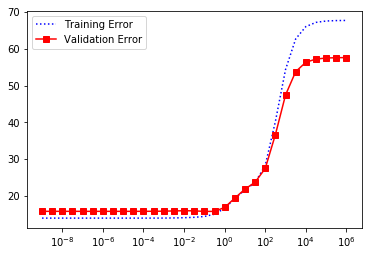

In [308]:
err_tr_list=[]
err_va_list=[]
for alphaV in alpha_grid:
    
    reg=make_L2regularized_pipeline(degree=2, alpha=alphaV)
    reg.fit(x_tr_MF, y_tr_M)
    
    #get training mse
    dif_tr=y_tr_M-reg.predict(x_tr_MF)
    mse_tr=1/dif_tr.shape[0]*np.dot(dif_tr,dif_tr)
    err_tr_list.append(mse_tr)
    
    #get valid mse
    dif_va=y_va_N-reg.predict(x_va_NF)
    mse_va=1/dif_va.shape[0]*np.dot(dif_va,dif_va)
    err_va_list.append(mse_va)
    ##print(alphaV,mse_tr)
fig,ax = plt.subplots()
ax.plot(alpha_grid,err_tr_list,'b:',  label="Training Error")     
ax.plot(alpha_grid,err_va_list,'rs-', label="Validation Error")
plt.xscale('log')
plt.legend()
plt.show()

### **2a(ii):** Make the same plot at degree 6

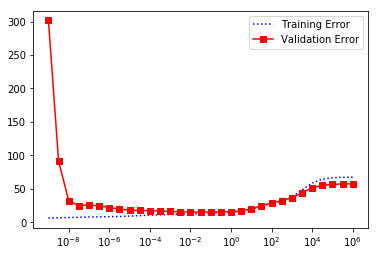

In [309]:
err_tr_list=[]
err_va_list=[]
pipeline_list=[]
for alphaV in alpha_grid:
    
    reg=make_L2regularized_pipeline(degree=6, alpha=alphaV)
    reg.fit(x_tr_MF, y_tr_M)
    
    #get training mse
    dif_tr=y_tr_M-reg.predict(x_tr_MF)
    mse_tr=1/dif_tr.shape[0]*np.dot(dif_tr,dif_tr)
    err_tr_list.append(mse_tr)
    
    #get valid mse
    dif_va=y_va_N-reg.predict(x_va_NF)
    mse_va=1/dif_va.shape[0]*np.dot(dif_va,dif_va)
    err_va_list.append(mse_va)
    ##print(alphaV,mse_tr)
    
    pipeline_list.append(reg)
fig,ax = plt.subplots()
ax.plot(alpha_grid,err_tr_list,'b:',  label="Training Error")     
ax.plot(alpha_grid,err_va_list,'rs-', label="Validation Error")
plt.xscale('log')
plt.legend()
plt.show()

### 2a(iii): How does the recommended $\alpha$ change from deg. 2 to 6?

**Answer**:  
I will recomend a small alpha for degree 2(<0.01). But will recommend a median alpha (between 0.01 and 1) for degree 6.

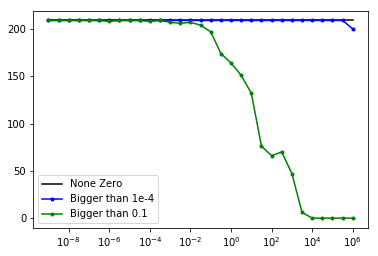

In [310]:
c1=[]
c2=[]
c3=[]

for regr in pipeline_list:
    ft=regr.get_linear_regr_weights()
    ct1=0; ct2=0; ct3=0;
    
    for i in ft:
        i=np.abs(i);
        if (i!=0):
            ct1=ct1+1
        if i>0.0001:
            ct2=ct2+1
        if i>0.1:
            ct3=ct3+1
    #print(ct1,ct2,ct3)
    c1.append(ct1);
    c2.append(ct2);
    c3.append(ct3);
fig,ax = plt.subplots()
ax.plot(alpha_grid,c1,'k-',  label="None Zero")     
ax.plot(alpha_grid,c2,'b.-', label="Bigger than 1e-4")
ax.plot(alpha_grid,c3,'g.-', label="Bigger than 0.1")
plt.xscale('log')
plt.legend()
plt.show()

## Problem 2b: Grid search for L1

In [311]:
def make_L1regularized_pipeline(degree=2, alpha=1.0):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('poly_rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('linear_regr', sklearn.linear_model.Lasso(alpha=alpha, max_iter=50000)),
        ])
    
    # Define utility method that performs all the feature transforms of the pipeline in order.
    def calc_features(x):
        tmp = x
        for step_name, step_tfmr in pipeline.steps[:-1]:
            tmp = step_tfmr.transform(tmp)
        return tmp
    pipeline.calc_features = calc_features
    pipeline.degree=degree
    pipeline.alpha=alpha
    pipeline.get_feature_names=lambda: pipeline.named_steps['poly_transformer'].get_feature_names \
                                (['horsepower', 'weight', 'cylinders', 'displacement'])
    pipeline.get_linear_regr_weights = lambda: pipeline.named_steps['linear_regr'].coef_
    pipeline.get_linear_regr_bias = lambda: pipeline.named_steps['linear_regr'].intercept_

    return pipeline

In [312]:
alpha_grid = np.logspace(-9, 6, 31)
degree = 3
err_tr_list2 = []
err_va_list2 = []
pipeline_list = []
for alpha in alpha_grid: # TODO loop over all alpha_grid
    
    # Create pipeline with specified alpha
    pipeline = make_L1regularized_pipeline(alpha=alpha, degree=degree)

    # L1 solvers are a bit more finicky than L2 solvers
    # Here's some code that will show if each optimization has converged
    with warnings.catch_warnings(record=True) as warn_list:
        pipeline.fit(x_tr_MF, y_tr_M)
        solver = pipeline.named_steps['linear_regr']
        print("alpha % .3e | %s | completed %5d iters | gap % 10.3f" % (
            alpha, 
            'converged    ' if len(warn_list) == 0 else 'NOT converged',
            solver.n_iter_, solver.dual_gap_))

    # TODO evaluation code here
    #get training mse
    dif_tr=y_tr_M-pipeline.predict(x_tr_MF)
    mse_tr=1/dif_tr.shape[0]*np.dot(dif_tr,dif_tr)
    err_tr_list2.append(mse_tr)
    
    #get valid mse
    dif_va=y_va_N-pipeline.predict(x_va_NF)
    mse_va=1/dif_va.shape[0]*np.dot(dif_va,dif_va)
    err_va_list2.append(mse_va)
    
    pipeline_list.append(pipeline)

alpha  1.000e-09 | NOT converged | completed 50000 iters | gap   1158.062
alpha  3.162e-09 | NOT converged | completed 50000 iters | gap   1158.054
alpha  1.000e-08 | NOT converged | completed 50000 iters | gap   1158.028
alpha  3.162e-08 | NOT converged | completed 50000 iters | gap   1157.948
alpha  1.000e-07 | NOT converged | completed 50000 iters | gap   1157.693
alpha  3.162e-07 | NOT converged | completed 50000 iters | gap   1156.888
alpha  1.000e-06 | NOT converged | completed 50000 iters | gap   1154.329
alpha  3.162e-06 | NOT converged | completed 50000 iters | gap   1146.134
alpha  1.000e-05 | NOT converged | completed 50000 iters | gap   1119.175
alpha  3.162e-05 | NOT converged | completed 50000 iters | gap   1023.272
alpha  1.000e-04 | NOT converged | completed 50000 iters | gap    548.999
alpha  3.162e-04 | NOT converged | completed 50000 iters | gap     17.487
alpha  1.000e-03 | converged     | completed 33186 iters | gap      1.285
alpha  3.162e-03 | converged     | com

### 2b(i): Plot MSE vs. $\alpha$ for L1 ("Lasso")

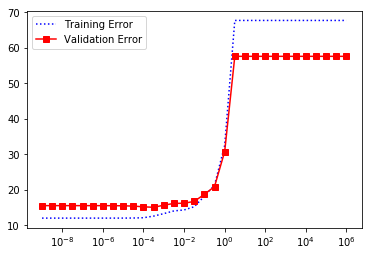

In [313]:
# TODO make plot
fig,ax = plt.subplots()
ax.plot(alpha_grid,err_tr_list2,'b:', label="Training Error")     
ax.plot(alpha_grid,err_va_list2,'rs-',label="Validation Error")
plt.xscale('log')
plt.legend()
plt.show()

### 2b(ii): Plot number of non-zero coefficients

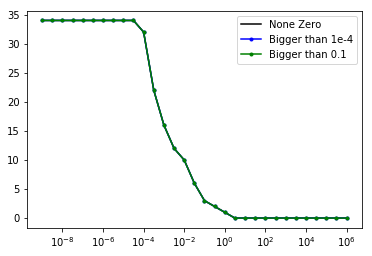

In [314]:
# TODO make plot
c1=[]
c2=[]
c3=[]

for regr in pipeline_list:
    ft=regr.get_linear_regr_weights()
    ct1=0; ct2=0; ct3=0;
    
    for i in ft:
        i=np.abs(i);
        if (i!=0):
            ct1=ct1+1
        if i>0.0001:
            ct2=ct2+1
        if i>0.1:
            ct3=ct3+1
    #print(ct1,ct2,ct3)
    c1.append(ct1);
    c2.append(ct2);
    c3.append(ct3);
fig,ax = plt.subplots()
ax.plot(alpha_grid,c1,'k-', label="None Zero")     
ax.plot(alpha_grid,c2,'b.-',label="Bigger than 1e-4")
ax.plot(alpha_grid,c3,'g.-',label="Bigger than 0.1")
plt.xscale('log')
plt.legend()
plt.show()

### 2b(iii): Print out non-zero coefficients of learned L1-regularized models

In [315]:
%%javascript 
IPython.OutputArea.auto_scroll_threshold = 999;

<IPython.core.display.Javascript object>

In [316]:
# TODO write code
for regr in pipeline_list:
    feat_names=regr.get_feature_names()
    ft=regr.get_linear_regr_weights()
    ##print(feat_names)
    for i in range(0, len(feat_names)):
        if (np.abs(ft[i])>0):
            print("Degree:", regr.degree, "Alpha", regr.alpha, "Features: ", feat_names[i], 'Value: ', ft[i])
    
    print("\n")

Degree: 3 Alpha 1e-09 Features:  horsepower Value:  -53.147550695778925
Degree: 3 Alpha 1e-09 Features:  weight Value:  25.531139193466853
Degree: 3 Alpha 1e-09 Features:  cylinders Value:  -33.34805711019896
Degree: 3 Alpha 1e-09 Features:  displacement Value:  -48.87783314630452
Degree: 3 Alpha 1e-09 Features:  horsepower^2 Value:  -43.46510302245697
Degree: 3 Alpha 1e-09 Features:  horsepower weight Value:  -84.43138935669201
Degree: 3 Alpha 1e-09 Features:  horsepower cylinders Value:  131.85007836046782
Degree: 3 Alpha 1e-09 Features:  horsepower displacement Value:  232.607878432983
Degree: 3 Alpha 1e-09 Features:  weight^2 Value:  -14.046929480514686
Degree: 3 Alpha 1e-09 Features:  weight cylinders Value:  55.009490394081865
Degree: 3 Alpha 1e-09 Features:  weight displacement Value:  -128.1026855927005
Degree: 3 Alpha 1e-09 Features:  cylinders^2 Value:  62.306599974189666
Degree: 3 Alpha 1e-09 Features:  cylinders displacement Value:  -246.7387566047817
Degree: 3 Alpha 1e-09 

Degree: 3 Alpha 3.162277660168379e-08 Features:  cylinders displacement^2 Value:  69.34260032178958
Degree: 3 Alpha 3.162277660168379e-08 Features:  displacement^3 Value:  -56.60696545879814


Degree: 3 Alpha 1e-07 Features:  horsepower Value:  -53.142736423467205
Degree: 3 Alpha 1e-07 Features:  weight Value:  25.529934370969098
Degree: 3 Alpha 1e-07 Features:  cylinders Value:  -33.326355175576516
Degree: 3 Alpha 1e-07 Features:  displacement Value:  -48.87903076448847
Degree: 3 Alpha 1e-07 Features:  horsepower^2 Value:  -43.456411074263485
Degree: 3 Alpha 1e-07 Features:  horsepower weight Value:  -84.43683518796618
Degree: 3 Alpha 1e-07 Features:  horsepower cylinders Value:  131.81769599031196
Degree: 3 Alpha 1e-07 Features:  horsepower displacement Value:  232.60651720552355
Degree: 3 Alpha 1e-07 Features:  weight^2 Value:  -14.049972733442972
Degree: 3 Alpha 1e-07 Features:  weight cylinders Value:  54.99557357180505
Degree: 3 Alpha 1e-07 Features:  weight displacement Value:  

Degree: 3 Alpha 3.162277660168379e-06 Features:  horsepower weight displacement Value:  239.86527203878913
Degree: 3 Alpha 3.162277660168379e-06 Features:  horsepower cylinders^2 Value:  -3.3212395517750033
Degree: 3 Alpha 3.162277660168379e-06 Features:  horsepower cylinders displacement Value:  -253.46957813640557
Degree: 3 Alpha 3.162277660168379e-06 Features:  horsepower displacement^2 Value:  -271.5525405190314
Degree: 3 Alpha 3.162277660168379e-06 Features:  weight^3 Value:  -23.611649061087427
Degree: 3 Alpha 3.162277660168379e-06 Features:  weight^2 cylinders Value:  12.508899548428928
Degree: 3 Alpha 3.162277660168379e-06 Features:  weight^2 displacement Value:  -23.358653345092243
Degree: 3 Alpha 3.162277660168379e-06 Features:  weight cylinders^2 Value:  63.84288983019939
Degree: 3 Alpha 3.162277660168379e-06 Features:  weight cylinders displacement Value:  26.90778444031019
Degree: 3 Alpha 3.162277660168379e-06 Features:  weight displacement^2 Value:  -34.00846761653505
Deg

Degree: 3 Alpha 0.00031622776601683794 Features:  displacement^2 Value:  70.16274241750956
Degree: 3 Alpha 0.00031622776601683794 Features:  horsepower^3 Value:  19.532409577584737
Degree: 3 Alpha 0.00031622776601683794 Features:  horsepower^2 displacement Value:  2.274068537735038
Degree: 3 Alpha 0.00031622776601683794 Features:  horsepower weight^2 Value:  38.39581789455468
Degree: 3 Alpha 0.00031622776601683794 Features:  horsepower weight displacement Value:  13.835572251525182
Degree: 3 Alpha 0.00031622776601683794 Features:  horsepower cylinders^2 Value:  -31.93451403334911
Degree: 3 Alpha 0.00031622776601683794 Features:  horsepower cylinders displacement Value:  -74.62290407753798
Degree: 3 Alpha 0.00031622776601683794 Features:  horsepower displacement^2 Value:  -83.0705894367483
Degree: 3 Alpha 0.00031622776601683794 Features:  weight^2 displacement Value:  -2.6161378280450176
Degree: 3 Alpha 0.00031622776601683794 Features:  weight cylinders^2 Value:  23.464074812307857
Degr

## Problem 3

### 3a: Adding fake observations to a no-bias linear regression


**Question:** 
You are given a training dataset for regression $\{x_n, y_n \}_{n=1}^N$. Each feature vector $x_n$ has size $F=4$. Each $y_n$ is a scalar.

You decide to add in the following additional "fake" observations $\tilde{x}$:

\begin{align}
\begin{array}{c c c c}
    ~\sqrt{\lambda}  & 0  & 0 & 0
 \\ 0  & \sqrt{\lambda}  & 0  & 0
 \\ 0  &0 & \sqrt{\lambda} &0
 \\ 0  & 0  & 0  &\sqrt{\lambda}
\end{array}
\end{align}

You also add in 4 "fake" responses $\tilde{y}$, all equal to zero.

You then wish to fit a least squares linear regression model with no bias/intercept term to the combined labeled dataset that is the union of $x$ and $\tilde{x}$, $y$ and $\tilde{y}$.

Write down the optimization objective and simplify as much as possible. Is this "add fake data" process interpretable as some kind of regularization?



## Answer:
(i) For the first n $x_n$, the sum of squared error is $\sum_1^N [y_n-w*x_n]^2$. For the last 4 fake obeservation, the sum of squared error is:
$$
\begin{align}
\sum_1^4 [y_n-w\tilde{x}_n]^2 &=\sum_1^4 [0-w_n*\sqrt{\lambda}]^2=\lambda(w_1^2+w_2^2+w_3^3+w_4^2)\\
&=\lambda\sum_1^4 w_n^2
\end{align}
$$
So the least square problem becomes optimizing $\frac{1}{N+F}[\sum_1^N (y_n-w*x_n)^2+\lambda\sum_1^F w_n^2]$ with $F=4$. This is the same problem as optimizing $\frac{1}{2}[\sum_1^N (y_n-w*x_n)^2+\lambda\sum_1^F w_n^2]$ = $\frac{1}{2}\sum_1^N (y_n-w*x_n)^2+\lambda'\sum_1^F w_n^2$, (where $\lambda'=\lambda/2$).
  
(ii) This is the same problem of $L2$-penalty regularized linear regression.